# 1. Import Libraries & Data

In [76]:
# general imports that we will need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set()

# data partition
from sklearn.model_selection import train_test_split

# filter methods
# - spearman 
# - chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
# embedded methods
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
# Scaler
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Custom functions and variables
from functions import histogram_boxplot, labeled_barplot, stacked_barplot, distribution_plot_wrt_target, comparative_boxplot, comparative_barplot, detect_outliers_iqr
from vocab_prep import BRAND_MODEL_VOCAB

#set random seed for reproducibility
RSEED = 42
np.random.seed(RSEED)
pd.set_option('display.max_rows', 500)


#### Data Loading

In [77]:
train = pd.read_csv('train_data_EDA.csv')

test = pd.read_csv('test_data_EDA.csv')

In [78]:
train.head()

,carID,price,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,model,hasDamage
0,0,10990,57097.0,0.0,83.1,1.6,75.0,4.0,9.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,a3,0.0
1,1,22999,24337.0,150.0,55.4,3.0,31.0,0.0,8.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,a7,0.0
2,2,14242,14900.0,125.0,53.3,1.4,65.0,4.0,9.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,a4,0.0
3,3,15998,37151.0,145.0,51.4,1.4,55.0,1.0,8.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,q3,0.0
4,4,30850,4553.0,145.0,47.9,2.0,62.0,0.0,6.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,a6,0.0


# 2. Train-Test Split

**Holdout Method**

In [79]:
# Split the DataFrame into features (X) and target variable (y)
X = train.drop('price', axis=1) 
y = train['price']  

In [80]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0) 

# 3. Feature Engineering

## 3.1 Encoding

Categorical Variables = "Brand","model","transmission","fuelType", but since we have already encoded "Brand", "transmission" and "fueltype", only "model" lefts

***model***

In [81]:
X_train['model'].value_counts()

model
focus                    5549
c class                  4212
fiesta                   3613
golf                     2650
corsa                    1868
polo                     1781
astra                    1501
a class                  1385
3 series                 1377
unknown                  1208
kuga                     1190
yaris                    1145
mokka x                  1130
aygo                     1104
1 series                 1102
e class                  1063
a3                       1023
tiguan                    983
fabia                     857
octavia                   813
q3                        788
a4                        744
a1                        727
tucson                    722
2 series                  672
ecosport                  647
insignia                  585
i10                       579
5 series                  568
4 series                  529
glc class                 526
passat                    513
up                        488
q5  

In [82]:
# Compute mean engineSize per model
tmp = X_train[['model', 'engineSize']].copy()
model_mean_engine = tmp.groupby('model')['engineSize'].mean()

# Compute global mean (fallback for unseen models)
global_mean_engine = X_train['engineSize'].mean()

def encoding_model(input_df):

    # Apply encoding
    input_df['model_te'] = input_df['model'].map(model_mean_engine).fillna(global_mean_engine)

    # Drop the original 'model' column to avoid redundancy
    input_df.drop(columns=['model'], inplace=True)

    return input_df


In [83]:
X_train = encoding_model(X_train)

X_val = encoding_model(X_val)

test_encoded = encoding_model(test)

In [84]:
X_train.sample(10)

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
13095,13095,36075.0,30.0,62.8,2.0,63.0,2.0,12.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.890085
58660,58666,10008.0,145.0,43.5,1.4,65.0,4.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.362481
38856,38861,19779.0,145.0,67.3,2.1,34.0,4.0,8.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.032058
51419,51425,67000.0,265.0,42.2,2.2,54.0,4.0,12.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.245092
15147,15147,42750.0,125.0,56.5,2.0,70.0,2.0,9.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.969431
51197,51203,34000.0,0.0,72.4,1.8,55.0,1.0,12.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.673080
41648,41653,10803.0,145.0,60.1,1.6,52.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.032058
11884,11884,94643.0,205.0,47.1,3.0,59.0,3.0,10.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.015178
61084,61091,44086.0,30.0,54.3,1.4,42.0,1.0,10.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.650023
20500,20500,6238.0,145.0,64.2,1.1,NaN,2.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.106611


In [85]:
X_val.sample(10)

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
29138,29141,12621.0,NaN,NaN,1.0,85.0,4.0,7.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.374155
20419,20419,5244.0,NaN,62.8,1.0,46.0,3.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.106611
56778,56784,10218.0,NaN,56.5,1.5,40.0,2.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.348264
36354,36359,33719.0,145.0,55.4,2.1,57.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.006776
50663,50669,10912.0,150.0,40.9,1.5,66.0,1.0,6.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.838407
5110,5110,NaN,145.0,48.7,1.8,70.0,3.0,10.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.082504
17513,17513,15695.0,150.0,48.7,1.0,80.0,4.0,6.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.106611
19741,19741,13450.0,145.0,38.2,1.5,31.0,4.0,8.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.819975
5901,5901,5015.0,150.0,53.3,1.6,69.0,4.0,5.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.657699
41143,41148,3414.0,NaN,NaN,2.0,33.0,1.0,6.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.032058


## 3.2 Missing Values

In [86]:
X_train.isna().sum()

carID                        0
mileage                   1455
tax                       6647
mpg                       6400
engineSize                1438
paintQuality%             1794
previousOwners            1826
carAge                    1191
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                 1233
model_te                     0
dtype: int64

### 2.1 Dealing with Missing Values

previousOwners

In [87]:
X_train['previousOwners'] = X_train['previousOwners'].fillna(0)
X_val['previousOwners'] = X_val['previousOwners'].fillna(0)
test_encoded['previousOwners'] = test_encoded['previousOwners'].fillna(0)

In [88]:
X_train['previousOwners'].unique()

array([4., 2., 0., 1., 3.])

hasDamage

In [89]:
X_train['hasDamage']=X_train['hasDamage'].fillna(0)
X_val['hasDamage'] = X_val['hasDamage'].fillna(0)
test_encoded['hasDamage'] = test_encoded['hasDamage'].fillna(0)

In [90]:
X_train['hasDamage'].unique()

array([0.])

engineSize

In [91]:
X_train['engineSize'].unique()

array([1.        , 1.2       , 1.5       , 1.6       , 2.        ,
       2.1       , 1.4       , 1.8       ,        nan, 4.4       ,
       3.        , 1.7       , 1.3       , 2.2       , 0.16286595,
       2.3       , 4.        , 0.7395339 , 0.19146242, 3.72371217,
       0.37112737, 1.1       , 6.2       , 2.5       , 2.61964142,
       2.63120047, 0.30707394, 4.3       , 4.2       , 0.18642488,
       2.06411863, 2.6631132 , 1.9       , 2.9       , 5.5       ,
       2.98579344, 5.        , 0.15452932, 2.4       , 3.82275785,
       2.8       , 5.2       , 3.73923548, 3.2       , 4.7       ,
       0.31340658, 2.78177621, 3.5       , 0.6       , 6.6       ,
       2.7       , 2.6       , 4.5       , 6.        , 3.6       ,
       5.4       ])

In [92]:
# Compute median engineSize per model 
engine_median_by_model = (
    X_train.groupby('model_te')['engineSize']
           .median()
)

global_median_engine = X_train['engineSize'].median() 

def impute_engine_size(df, per_model_median, global_median_engine):
    df['engineSize'] = (
        df['engineSize']
          .fillna(df['model_te'].map(per_model_median))
          .fillna(global_median_engine)
    )
    return df


In [93]:
# Fill NaN values in TRAIN using the per-model median
X_train  = impute_engine_size(X_train,  engine_median_by_model, global_median_engine)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_engine_size(X_val, engine_median_by_model, global_median_engine)

test_encoded = impute_engine_size(test_encoded, engine_median_by_model, global_median_engine)

In [94]:
X_train.isna().sum()

carID                        0
mileage                   1455
tax                       6647
mpg                       6400
engineSize                   0
paintQuality%             1794
previousOwners               0
carAge                    1191
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                    0
model_te                     0
dtype: int64

carAge

In [95]:
# Compute median carAge per model (using TRAIN only)
carAge_median_by_model = (
    X_train.groupby('model_te')['carAge']
    .median()
)

global_median_carAge = X_train['carAge'].median() 

def impute_carAge(df, per_model_median, global_median_carAge):
    
    df['carAge'] = df.apply(
    lambda row: carAge_median_by_model[row['model_te']]
    if pd.isna(row['carAge']) and row['model_te'] in carAge_median_by_model
    else row['carAge'],
    axis=1)

    return df


In [96]:
# Fill NaN values in TRAIN using the per-model median
X_train  = impute_carAge(X_train, carAge_median_by_model, global_median_carAge)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_carAge(X_val, carAge_median_by_model, global_median_carAge)

test_encoded = impute_carAge(test_encoded, carAge_median_by_model, global_median_carAge)

mileage

In [97]:
mileage_median_by_age = (
    X_train.groupby('carAge')['mileage']
    .median()
)

def impute_mileage(df, per_model_median):

    df['mileage'] = df.apply(
        lambda row: mileage_median_by_age[row['carAge']]
        if pd.isna(row['mileage']) and row['carAge'] in mileage_median_by_age
        else row['mileage'],
        axis=1)
    
    return df


In [98]:
X_train  = impute_mileage(X_train, mileage_median_by_age)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_mileage(X_val, mileage_median_by_age)

test_encoded = impute_mileage(test_encoded, mileage_median_by_age)

In [99]:
X_train.isna().sum()

carID                        0
mileage                      0
tax                       6647
mpg                       6400
engineSize                   0
paintQuality%             1794
previousOwners               0
carAge                       0
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                    0
model_te                     0
dtype: int64

paintQuality%

In [100]:
# Compute median paintQuality% per carAge (using TRAIN only)
paintQuality_median_by_age = (
    X_train.groupby('carAge')['paintQuality%']
    .median()
)

def impute_paintQuality(df, per_model_median):

    df['paintQuality%'] = df.apply(
    lambda row: paintQuality_median_by_age[row['carAge']]
    if pd.isna(row['paintQuality%']) and row['carAge'] in paintQuality_median_by_age
    else row['paintQuality%'],
    axis=1)
    
    return df

In [101]:
X_train  = impute_paintQuality(X_train, paintQuality_median_by_age)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_paintQuality(X_val, paintQuality_median_by_age)

test_encoded = impute_paintQuality(test_encoded, paintQuality_median_by_age)

In [102]:
X_train.isna().sum()

carID                        0
mileage                      0
tax                       6647
mpg                       6400
engineSize                   0
paintQuality%                0
previousOwners               0
carAge                       0
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                    0
model_te                     0
dtype: int64

tax

In [103]:
# Compute median tax per model (using TRAIN only)
tax_median_by_model = (
    X_train.groupby('model_te')['tax']
    .median()
)

def impute_tax(df, per_model_median):
   
   df['tax'] = df.apply(
    lambda row: tax_median_by_model[row['model_te']]
    if pd.isna(row['tax']) and row['model_te'] in tax_median_by_model
    else row['tax'],
    axis=1)
    
   return df

In [104]:
X_train  = impute_tax(X_train, tax_median_by_model)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_tax(X_val, tax_median_by_model)

test_encoded = impute_tax(test_encoded, tax_median_by_model)

In [105]:
X_train.isna().sum()

carID                        0
mileage                      0
tax                          0
mpg                       6400
engineSize                   0
paintQuality%                0
previousOwners               0
carAge                       0
Brand_audi                   0
Brand_bmw                    0
Brand_ford                   0
Brand_hyundai                0
Brand_mercedes-benz          0
Brand_opel                   0
Brand_skoda                  0
Brand_toyota                 0
Brand_unknown                0
Brand_volkswagen             0
transmission_automatic       0
transmission_manual          0
transmission_semi-auto       0
fuelType_diesel              0
fuelType_electric            0
fuelType_hybrid              0
fuelType_petrol              0
hasDamage                    0
model_te                     0
dtype: int64

mpg

In [106]:
# Compute median mpg per model (using TRAIN only)
mpg_median_by_model = (
    X_train.groupby('model_te')['mpg']
    .median()
)

def impute_mpg(df, per_model_median):
   
   df['mpg'] = df.apply(
    lambda row: mpg_median_by_model[row['model_te']]
    if pd.isna(row['mpg']) and row['model_te'] in mpg_median_by_model
    else row['mpg'],
    axis=1)
    
   return df

In [107]:
X_train  = impute_mpg(X_train, mpg_median_by_model)
# Fill NaN values in VAL using the same medians learned from TRAIN
X_val = impute_mpg(X_val, mpg_median_by_model)

test_encoded = impute_mpg(test_encoded, mpg_median_by_model)

In [108]:
X_train.isna().sum()

carID                     0
mileage                   0
tax                       0
mpg                       0
engineSize                0
paintQuality%             0
previousOwners            0
carAge                    0
Brand_audi                0
Brand_bmw                 0
Brand_ford                0
Brand_hyundai             0
Brand_mercedes-benz       0
Brand_opel                0
Brand_skoda               0
Brand_toyota              0
Brand_unknown             0
Brand_volkswagen          0
transmission_automatic    0
transmission_manual       0
transmission_semi-auto    0
fuelType_diesel           0
fuelType_electric         0
fuelType_hybrid           0
fuelType_petrol           0
hasDamage                 0
model_te                  0
dtype: int64

## 3.3 Outliers

### Outlier detection

Column: mileage - Number of Outliers: 2627
Column: mileage - % of Outliers: 4.32%



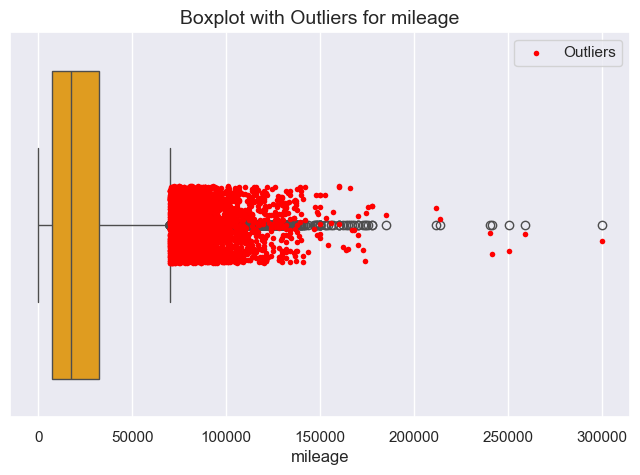

Column: tax - Number of Outliers: 15988
Column: tax - % of Outliers: 26.31%



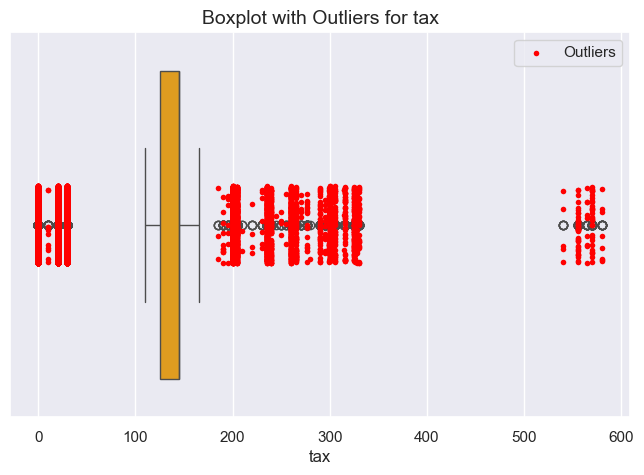

Column: mpg - Number of Outliers: 1351
Column: mpg - % of Outliers: 2.22%



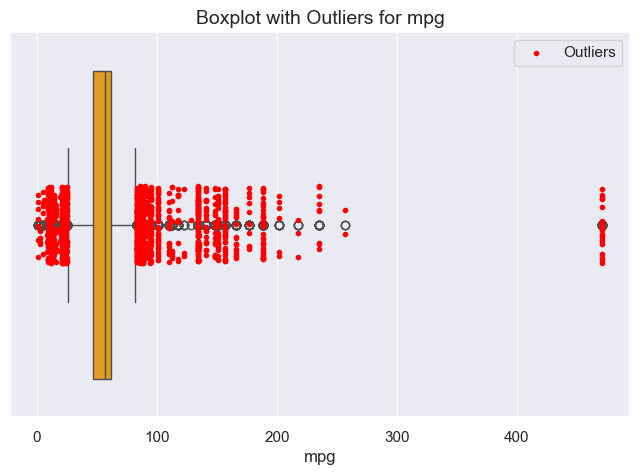

Column: engineSize - Number of Outliers: 521
Column: engineSize - % of Outliers: 0.86%



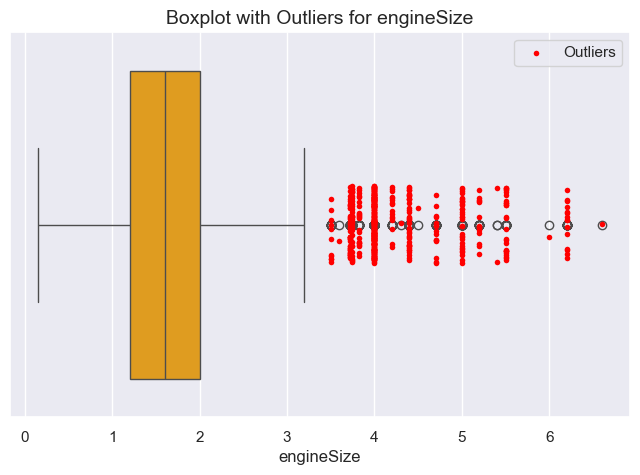

Column: paintQuality% - Number of Outliers: 0
Column: paintQuality% - % of Outliers: 0.00%



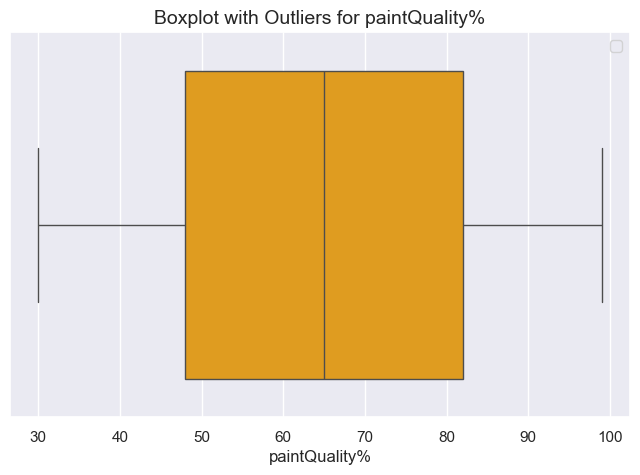

Column: previousOwners - Number of Outliers: 0
Column: previousOwners - % of Outliers: 0.00%



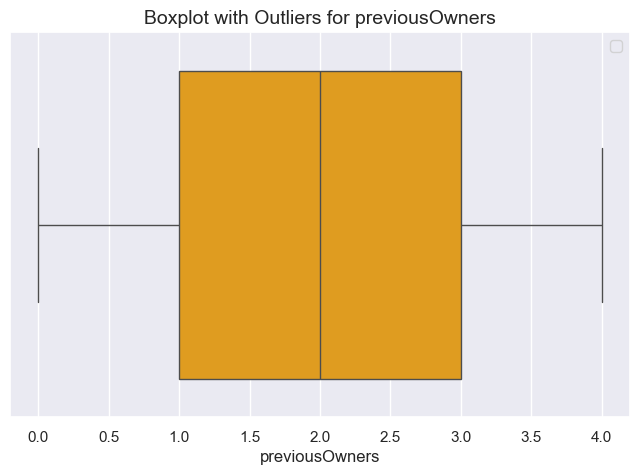

Column: carAge - Number of Outliers: 1436
Column: carAge - % of Outliers: 2.36%



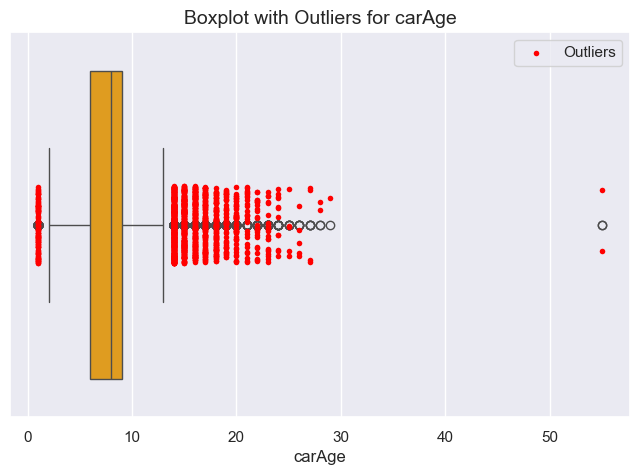

,Column,Num_Outliers,Pct_Outliers
0,mileage,2627,4.322714
1,tax,15988,26.308168
2,mpg,1351,2.223063
3,engineSize,521,0.857303
4,carAge,1436,2.362930


In [109]:
detect_outliers_iqr(X_train[['mileage','tax','mpg','engineSize','paintQuality%','previousOwners','carAge']], threshold=0.001)

### Dealing with outliers

***mileage***

In [110]:
X_train[X_train['mileage'] > 250000]

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
45364,45370,259000.0,540.0,30.7,3.0,54.0,1.0,15.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.102941
48376,48382,300000.0,125.0,57.6,1.9,79.0,2.0,15.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.638523
48036,48042,250650.0,125.0,57.6,1.9,62.0,1.0,15.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.638523


Since having more than 250000 miles in 15+ years is completely possible, we will not treat them as wrong values

***tax***

In [111]:
X_train[X_train['tax'] == 0]

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
52404,52410,17186.0,0.0,68.900000,1.0,65.0,4.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.996993
65765,65772,29892.0,0.0,74.300000,1.6,86.0,0.0,9.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.672114
55649,55655,24023.0,0.0,78.500000,1.8,39.0,2.0,9.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.673080
53596,53602,47141.0,0.0,78.500000,1.8,67.0,0.0,8.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.673080
66000,66007,15500.0,0.0,65.700000,1.0,83.0,2.0,9.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.672114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48682,48688,36941.0,0.0,78.600000,1.4,62.0,4.0,10.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.086371
55153,55159,21145.0,0.0,68.900000,1.0,88.0,1.0,8.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.996993
4420,4420,45644.0,0.0,80.700000,1.6,63.0,2.0,9.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.372543
51811,51817,39000.0,0.0,65.700000,1.0,73.0,0.0,12.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.996993


In [112]:
X_train.loc[(X_train['tax'] == 0) & (X_train['fuelType_electric'] == 1)].shape[0]

4

Since we have a lot of tax values (3371) = 0 and we do not know the specific laws of the country about the car taxes, we can't assume that those values are incorrect.

In [113]:
X_train[X_train['tax'] > 500].sample(20)

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
45640,45646,67000.0,555.0,28.8,3.0,71.0,0.0,18.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.716186
56440,56446,99500.0,565.0,32.8,2.0,87.0,3.0,18.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.181818
42429,42435,86000.0,555.0,30.4,3.0,55.0,4.0,16.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.716186
12545,12545,46000.0,570.0,22.6,4.4,80.0,3.0,14.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.015178
6752,6752,19800.0,570.0,22.8,4.2,70.0,3.0,11.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.964706
39732,39737,33271.0,580.0,23.9,5.5,30.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.716186
13819,13819,49000.0,570.0,25.4,3.0,98.0,4.0,9.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.015178
41847,41852,99000.0,555.0,28.8,2.5,56.0,3.0,18.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.032058
35300,35305,19953.0,555.0,28.0,5.5,77.0,2.0,9.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.252336
40605,40610,74000.0,570.0,28.8,3.0,96.0,1.0,18.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.285851


Since all cars with tax values higher than 500 either have "large" engine sizes, are "old," or are combustion-engine, which are usually factors that contribute to a higher tax values for cars, we will not consider these values ​​as outliers.

***mpg***

In [114]:
X_train[X_train['mpg']>400]

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
10327,10327,42479.0,0.0,470.8,0.600000,79.0,2.0,11.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.405689
12269,12269,26965.0,140.0,470.8,0.600000,81.0,3.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.405689
10653,10653,29851.0,0.0,470.8,0.600000,40.0,0.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.405689
13378,13378,9886.0,0.0,470.8,0.600000,44.0,0.0,10.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.405689
9196,9196,19995.0,0.0,470.8,0.600000,79.0,3.0,9.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.405689
12786,12786,29465.0,0.0,470.8,3.822758,67.0,2.0,10.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.405689
10133,10133,22200.0,0.0,470.8,0.600000,95.0,4.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.405689
11962,11962,21025.0,0.0,470.8,0.600000,66.0,0.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.405689
10695,10695,22200.0,135.0,470.8,0.600000,54.0,1.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.405689
13430,13430,41146.0,0.0,470.8,0.600000,69.0,1.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.405689


Since every car with > 400 mpg have the same brand and model, we do not consider those values as wrong values

***engineSize***

In [115]:
X_train[X_train['engineSize']>6]

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
38975,38980,43442.0,145.0,58.9,6.2,76.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.032058
35533,35538,49964.0,326.0,58.9,6.2,58.0,3.0,7.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.032058
35285,35290,56444.0,580.0,23.5,6.2,65.0,0.0,11.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.032058
37820,37825,55000.0,570.0,19.8,6.2,70.0,1.0,17.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.268558
39895,39900,19562.0,145.0,58.9,6.2,83.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.032058
36191,36196,86706.0,145.0,58.9,6.2,31.0,0.0,11.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.032058
39847,39852,38000.0,570.0,19.5,6.2,76.0,4.0,15.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.252336
44788,44794,37000.0,570.0,23.5,6.2,92.0,2.0,11.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.032058
9197,9197,11297.0,145.0,22.1,6.6,68.0,1.0,8.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.148077
46530,46536,44000.0,145.0,58.9,6.2,88.0,2.0,12.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.032058


Since all the cars with engineSize > 6 are all from the same brand (almost all from the same model) we will not considerer those values as wrong values

***carAge***

In [116]:
X_train[X_train['carAge']>50]

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
62725,62732,37357.0,200.0,42.2,1.4,60.0,2.0,55.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.499320
35764,35769,14000.0,305.0,39.2,3.0,44.0,3.0,55.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.716186


In [117]:
# --- aprender no TRAIN ---
carAge_median_by_model = X_train.groupby('model_te')['carAge'].median()
global_median_carAge   = float(X_train['carAge'].median())  # fallback

def replace_carAge_outliers(df, per_model_median, thr=50, global_med=None, to_int=True):
    out = df.copy()
    s = pd.to_numeric(out['carAge'], errors='coerce').astype('Float64')
    mask = s > thr

    # replace median by model
    repl = out.loc[mask, 'model_te'].map(per_model_median)
    if global_med is not None:
        repl = repl.fillna(global_med)

    s.loc[mask] = repl
    if to_int:
        s = s.round().astype('Int64') 
    out['carAge'] = s
    return out



In [118]:
X_train = replace_carAge_outliers(X_train, carAge_median_by_model, thr=50, global_med=global_median_carAge)
X_val = replace_carAge_outliers(X_val, carAge_median_by_model, thr=50, global_med=global_median_carAge)
test_encoded = replace_carAge_outliers(test_encoded, carAge_median_by_model, thr=50, global_med=global_median_carAge)

## 3.4 Scaling

We are going to use the "RobustScaler"

In [119]:
# Initialize the scaler
scaler = RobustScaler()

In [120]:
num = ['mileage', 'engineSize', 'tax', 'mpg', 'carAge', 'paintQuality%','previousOwners','model_te']

In [121]:
# Fit the scaler only on TRAIN data
scaler.fit(X_train[num])

# Transform both TRAIN and VALIDATION sets
X_train[num] = scaler.transform(X_train[num])
X_val[num] = scaler.transform(X_val[num])
test_encoded[num] = scaler.transform(test_encoded[num])

In [122]:
print(X_train[num].describe())

            mileage    engineSize           tax           mpg        carAge  \
count  60772.000000  60772.000000  60772.000000  60772.000000  60772.000000   
mean       0.235176      0.080995     -1.066329     -0.064014     -0.033552   
std        0.862497      0.704833      3.069969      1.106343      0.726288   
min       -0.698983     -1.806838     -7.250000     -3.874126     -2.333333   
25%       -0.398807     -0.500000     -1.000000     -0.657343     -0.666667   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.601193      0.500000      0.000000      0.342657      0.333333   
max       11.309623      6.250000     21.750000     28.972028      7.000000   

       paintQuality%  previousOwners      model_te  
count   60772.000000    60772.000000  60772.000000  
mean       -0.011459       -0.034243      0.012805  
std         0.585751        0.717981      0.742464  
min        -1.029412       -1.000000     -1.108717  
25%        -0.500000   

# 4.Feature Selection

In [123]:
X_train.columns

Index(['carID', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'carAge', 'Brand_audi', 'Brand_bmw', 'Brand_ford',
       'Brand_hyundai', 'Brand_mercedes-benz', 'Brand_opel', 'Brand_skoda',
       'Brand_toyota', 'Brand_unknown', 'Brand_volkswagen',
       'transmission_automatic', 'transmission_manual',
       'transmission_semi-auto', 'fuelType_diesel', 'fuelType_electric',
       'fuelType_hybrid', 'fuelType_petrol', 'hasDamage', 'model_te'],
      dtype='object')

In [124]:
numeric = [
    'mileage',
    'tax',
    'mpg',
    'engineSize',
    'paintQuality%',
    'previousOwners',
    'carAge',
    'model_te'
]


In [125]:
encoded_features = [
    'Brand_audi',
    'Brand_bmw',
    'Brand_ford',
    'Brand_hyundai',
    'Brand_mercedes-benz',
    'Brand_opel',
    'Brand_skoda',
    'Brand_toyota',
    'Brand_volkswagen',
    'transmission_automatic',
    'transmission_manual',
    'transmission_semi-auto',
    'fuelType_diesel',
    'fuelType_electric',
    'fuelType_hybrid',
    'fuelType_petrol'
]


In [126]:
binary_features = ['hasDamage']

In [127]:
categ_features = encoded_features + binary_features 

all_features = numeric + categ_features

### 4.1 Filter-Based Methods

In [128]:
X_train[numeric].var()

mileage           0.743902
tax               9.424712
mpg               1.223995
engineSize        0.496789
paintQuality%     0.343104
previousOwners    0.515497
carAge            0.527494
model_te          0.551254
dtype: float64

**Spearman Correlation Matrix**

In [129]:
cor_spearman = X_train[numeric].corr(method ='spearman')
cor_spearman

,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,model_te
mileage,1.000000,-0.247562,0.305354,0.094701,-0.002042,0.003960,0.785702,0.028258
tax,-0.247562,1.000000,-0.522405,0.149773,0.000260,0.001285,-0.304596,0.164102
mpg,0.305354,-0.522405,1.000000,-0.187120,0.002747,0.001295,0.288538,-0.232445
engineSize,0.094701,0.149773,-0.187120,1.000000,0.000781,0.006292,0.031412,0.809405
paintQuality%,-0.002042,0.000260,0.002747,0.000781,1.000000,-0.002935,-0.005037,-0.001773
previousOwners,0.003960,0.001285,0.001295,0.006292,-0.002935,1.000000,0.000608,0.002389
carAge,0.785702,-0.304596,0.288538,0.031412,-0.005037,0.000608,1.000000,-0.054012
model_te,0.028258,0.164102,-0.232445,0.809405,-0.001773,0.002389,-0.054012,1.000000


In [130]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = 'PiYG', fmt='.1')
    plt.show()

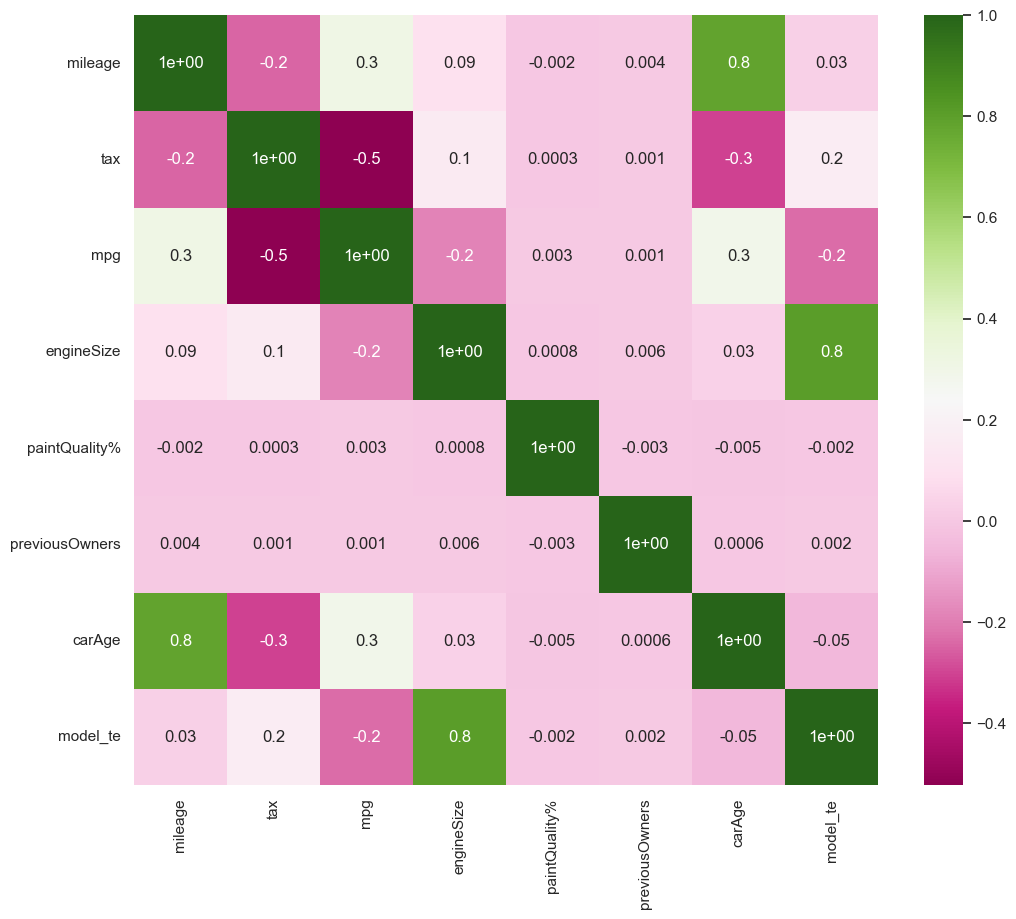

In [131]:
cor_heatmap(cor_spearman)

**Chi Squared Test**

In [132]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [133]:
for var in encoded_features:
    TestIndependence(X_train[var], y_train, var)

Brand_audi is IMPORTANT for Prediction
Brand_bmw is IMPORTANT for Prediction
Brand_ford is IMPORTANT for Prediction
Brand_hyundai is NOT an important predictor. (Discard Brand_hyundai from model)
Brand_mercedes-benz is IMPORTANT for Prediction
Brand_opel is IMPORTANT for Prediction
Brand_skoda is NOT an important predictor. (Discard Brand_skoda from model)
Brand_toyota is IMPORTANT for Prediction
Brand_volkswagen is IMPORTANT for Prediction
transmission_automatic is IMPORTANT for Prediction
transmission_manual is IMPORTANT for Prediction
transmission_semi-auto is IMPORTANT for Prediction
fuelType_diesel is IMPORTANT for Prediction
fuelType_electric is NOT an important predictor. (Discard fuelType_electric from model)
fuelType_hybrid is IMPORTANT for Prediction
fuelType_petrol is IMPORTANT for Prediction


In [134]:
X_train[X_train['Brand_hyundai'] == 1]

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
33566,33569,-0.261268,0.00,0.251748,-0.75,0.676471,-0.5,-0.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.960300
33496,33499,-0.414979,0.00,0.083916,-0.50,0.558824,-0.5,-0.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.012760
32023,32026,2.283964,-0.50,1.538462,0.00,-0.764706,1.0,-0.666667,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.012760
33024,33027,-0.026939,-0.50,1.538462,0.00,0.705882,-0.5,-0.333333,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.108683
32536,32539,-0.096710,0.00,-0.601399,-0.50,0.117647,-0.5,0.333333,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.960300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33538,33541,0.237651,0.00,-0.293706,-0.75,-0.970588,-0.5,-0.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.912228
33920,33923,-0.603354,0.00,-1.209790,0.75,0.441176,-0.5,-0.666667,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.887413
31785,31788,1.435674,-5.75,0.076923,-0.50,-0.058824,0.0,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.960300
31921,31924,-0.558922,0.00,-0.482517,-0.75,-0.235294,-1.0,-0.666667,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.960300


In [135]:
X_train[X_train['Brand_skoda'] == 1]

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
47310,47316,-0.549316,0.00,-1.384615,-0.125,-0.235294,-1.0,-0.666667,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.300400
48289,48295,0.051237,0.00,0.251748,-0.500,0.235294,0.0,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.949749
50019,50025,-0.096469,0.25,0.538462,0.500,-0.617647,-0.5,-0.333333,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.300400
49030,49036,-0.551797,0.25,-1.510490,0.500,-0.235294,-1.0,-1.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.213430
46931,46937,0.155312,0.00,0.000000,0.500,-1.029412,-0.5,-0.333333,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.213430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47883,47889,1.766552,0.00,0.251748,0.500,0.323529,-1.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.300400
49866,49872,2.197502,3.00,-0.818182,0.500,0.323529,-0.5,0.666667,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.376791
49811,49817,0.184012,0.00,0.440559,0.500,-0.794118,0.5,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.300400
47954,47960,0.210832,0.00,0.342657,-0.750,0.235294,-0.5,0.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.949749


In [136]:
X_train[X_train['fuelType_electric'] == 1]

,carID,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,carAge,Brand_audi,Brand_bmw,...,Brand_volkswagen,transmission_automatic,transmission_manual,transmission_semi-auto,fuelType_diesel,fuelType_electric,fuelType_hybrid,fuelType_petrol,hasDamage,model_te
12786,12786,0.480426,-7.25,28.972028,2.778447,0.058824,0.0,0.666667,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.418928
64162,64169,0.680410,-7.25,12.510490,-0.250000,0.529412,-0.5,0.666667,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.428386
16306,16306,-0.322912,-7.25,0.755245,0.500000,-0.176471,0.5,0.333333,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.405701
21930,21931,0.282924,-7.25,0.755245,0.500000,0.500000,1.0,0.333333,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.405701


### 4.2 Wrapper Methods

**RFE**

In [137]:
estimator = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=-1)

selector = RFE(
    estimator=estimator,
    n_features_to_select=12,   
    step=1,
    verbose=1
)

selector.fit(X_train, y_train)

selected_features = X_train.columns[selector.support_]
print("Selected features:", selected_features)

y_pred = estimator.fit(X_train[selected_features], y_train).predict(X_val[selected_features])
print("Validation MAE:", mean_absolute_error(y_val, y_pred))

Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Selected features: Index(['carID', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'carAge', 'Brand_bmw', 'transmission_manual',
       'fuelType_diesel', 'model_te'],
      dtype='object')
Validation MAE: 1365.797411478215


Best k = 8 with Validation MAE = 1351.132
Selected features: ['transmission_manual', 'carAge', 'engineSize', 'model_te', 'mileage', 'mpg', 'carID', 'tax']


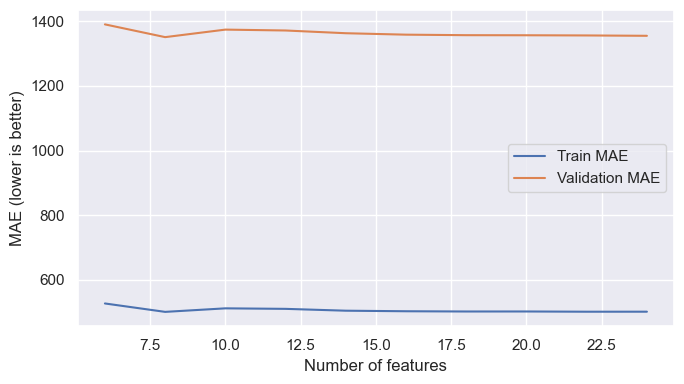

In [138]:
# Base model (smaller n_estimators during selection to be fast)
ranker = RandomForestRegressor(
    n_estimators=150,      # smaller for speed; increase later for final model
    random_state=42,
    n_jobs=-1
)
ranker.fit(X_train, y_train)

# Feature ranking by impurity-based importance (fast)
importances = ranker.feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_feats = X_train.columns[sorted_idx]

# 2) Sweep top-k subsets (10–15 fits only)
k_grid = list(range(6, min(26, X_train.shape[1] + 1), 2))  # e.g., 6,8,...,24
train_mae, val_mae = [], []
best_k, best_mae, best_feats = None, np.inf, None

for k in k_grid:
    feats_k = list(sorted_feats[:k])
    model_k = RandomForestRegressor(
        n_estimators=150,   # keep it light for the sweep
        random_state=42,
        n_jobs=-1
    )
    model_k.fit(X_train[feats_k], y_train)
    y_tr = model_k.predict(X_train[feats_k])
    y_va = model_k.predict(X_val[feats_k])

    tr_mae = mean_absolute_error(y_train, y_tr)
    va_mae = mean_absolute_error(y_val, y_va)
    train_mae.append(tr_mae)
    val_mae.append(va_mae)

    if va_mae < best_mae:
        best_mae = va_mae
        best_k = k
        best_feats = feats_k

print(f"Best k = {best_k} with Validation MAE = {best_mae:.3f}")
print("Selected features:", best_feats)

# 3) Retrain a stronger final model on the chosen features
final_model = RandomForestRegressor(
    n_estimators=400,  # now you can increase for accuracy
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train[best_feats], y_train)




plt.figure(figsize=(7,4))
plt.plot(k_grid, train_mae, label="Train MAE")
plt.plot(k_grid, val_mae, label="Validation MAE")
plt.xlabel("Number of features")
plt.ylabel("MAE (lower is better)")
plt.legend()
plt.tight_layout()
plt.show()

### 4.3 Embedded Methods

In [139]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [140]:
reg = LassoCV()

In [141]:
reg.fit(X_train[all_features], y_train)

LassoCV()

In [142]:
coef = pd.Series(reg.coef_, index = X_train[all_features].columns)
coef

mileage                  -2753.268112
tax                        -71.208647
mpg                       -541.995595
engineSize                4635.753900
paintQuality%              -48.491061
previousOwners               0.000000
carAge                   -3758.632669
model_te                  4259.063678
Brand_audi                2727.214737
Brand_bmw                   -0.000000
Brand_ford                 805.175339
Brand_hyundai            -1094.260457
Brand_mercedes-benz       2069.175368
Brand_opel               -2412.249093
Brand_skoda                 -0.000000
Brand_toyota             -1694.597980
Brand_volkswagen           851.386669
transmission_automatic      -0.000000
transmission_manual      -1685.398407
transmission_semi-auto     555.565676
fuelType_diesel          -1670.401347
fuelType_electric            0.000000
fuelType_hybrid           1906.809194
fuelType_petrol             -0.000000
hasDamage                    0.000000
dtype: float64

In [143]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 18 variables and eliminated the other 7 variables


In [144]:
coef.sort_values()

carAge                   -3758.632669
mileage                  -2753.268112
Brand_opel               -2412.249093
Brand_toyota             -1694.597980
transmission_manual      -1685.398407
fuelType_diesel          -1670.401347
Brand_hyundai            -1094.260457
mpg                       -541.995595
tax                        -71.208647
paintQuality%              -48.491061
fuelType_electric            0.000000
transmission_automatic      -0.000000
Brand_skoda                 -0.000000
hasDamage                    0.000000
Brand_bmw                   -0.000000
previousOwners               0.000000
fuelType_petrol             -0.000000
transmission_semi-auto     555.565676
Brand_ford                 805.175339
Brand_volkswagen           851.386669
fuelType_hybrid           1906.809194
Brand_mercedes-benz       2069.175368
Brand_audi                2727.214737
model_te                  4259.063678
engineSize                4635.753900
dtype: float64

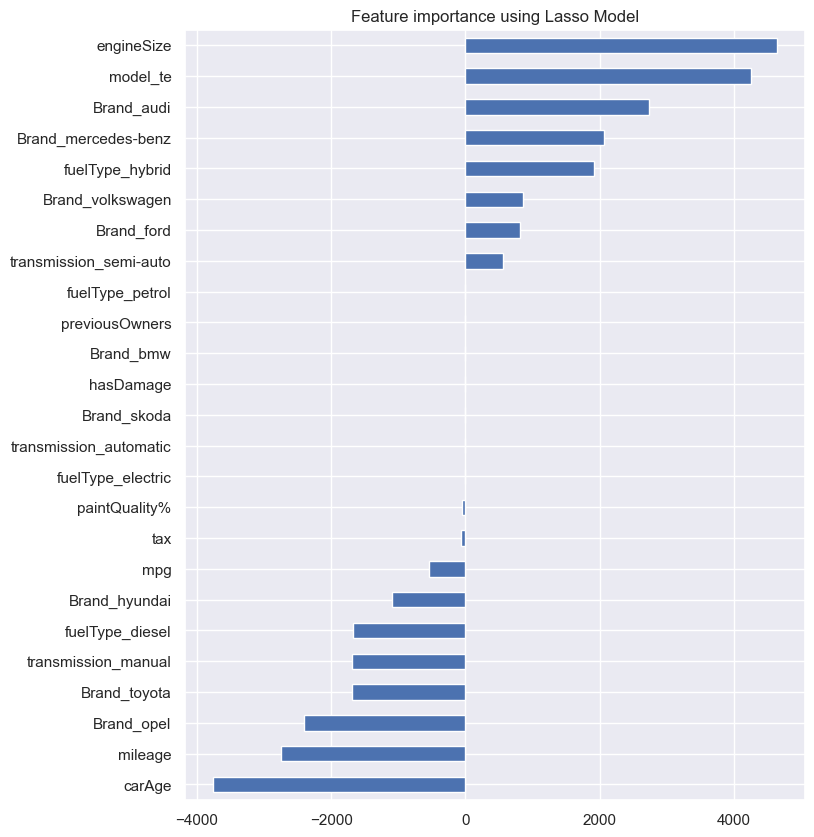

In [145]:
plot_importance(coef,'Lasso')

In [146]:
print(numeric, categ_features)

['mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'carAge', 'model_te'] ['Brand_audi', 'Brand_bmw', 'Brand_ford', 'Brand_hyundai', 'Brand_mercedes-benz', 'Brand_opel', 'Brand_skoda', 'Brand_toyota', 'Brand_volkswagen', 'transmission_automatic', 'transmission_manual', 'transmission_semi-auto', 'fuelType_diesel', 'fuelType_electric', 'fuelType_hybrid', 'fuelType_petrol', 'hasDamage']


### 4.4 Final Features

| Predictor              | Spearman  | RFE RF | Lasso | Chi-Square | What to do? (One possible way to "solve") |
|-------------------------|-----------------|---------|-------|-------------|--------------------------------------------|
| model_te               | Keep      | Keep    | Keep  | -           | Keep|
| engineSize             | Choose between 'model_te' and 'engineSize'       | Keep    | Keep  | -    | Try with and without                                      |
| Brand_ford             | -      | Keep      | Keep     | Keep           | Keep                                          |
| fuelType_hybrid        | -      | Keep    | Keep  | Keep          | Keep                      |
| Brand_audi             | -          | Keep       | Keep    | Keep           | Keep                                          |
| transmission_semi-auto | -        | Keep    | Keep  | Keep          | Keep                    |
| Brand_volkswagen       | -      | Keep    | Keep  | Keep           | Keep                      |
| Brand_mercedes-benz    | -          | Keep       | Keep     | Keep           | Keep                                          |
| previousOwners         | Discard     | Keep | Discard | -        | Discard                      |
| paintQuality%          | Discard     | Keep   | Discard     | -        | Discard                      |
| hasDamage              | -      | Discard    | Discard     | -        | Discard                      |
| fuelType_electric      | -      | Keep    | Discard     | Discard        | Discard                      |
| transmission_automatic | -      | Keep    | Discard     | Keep        | Try with and without                      |
| fuelType_petrol        | -      | Keep    | Discard     | Keep        | Try with and without                      |
| Brand_hyundai          | -     | Keep       | Keep     | Keep           | Keep                                         |
| Brand_bmw              | -       | Keep       | Discard     | Keep           | Try with and without                                          |
| Brand_skoda            | -       | Keep       | Discard   | Discard           | Discard                                          |
| tax                    | Keep        | Keep    | Keep  | -     | Keep                                      |
| Brand_opel             | -    | Keep       | Keep  | Keep           | Keep                                          |
| Brand_toyota           | -    | Keep       | Keep  | Keep           | Keep                                          |
| mpg                    | Keep     | Keep | Keep  | -       | Keep                      |
| transmission_manual    | -      | Keep    | Keep | Keep        | Keep                      |
| fuelType_diesel        | -     | Keep    | Keep | Keep        | Keep                      |
| mileage                | Keep       | Keep    | Keep | -     | Keep               |
| carAge                 | Choose between 'carAge' and 'mileage'      | Keep    | Keep | -       | Try with and without                      |


Let's create a new list with the selected features

In [147]:
cols_selected = ['mileage', 'tax', 'mpg', 'engineSize' , 'carAge', 'model_te','Brand_audi', 'Brand_bmw', 'Brand_ford', 'Brand_hyundai', 'Brand_mercedes-benz', 'Brand_opel',  'Brand_toyota', 'Brand_volkswagen', 'transmission_automatic', 'transmission_manual', 'transmission_semi-auto', 'fuelType_diesel',  'fuelType_hybrid', 'fuelType_petrol']

In [148]:
X_train_filtered = X_train[cols_selected]
X_val_filtered = X_val[cols_selected]
test_filtered = test_encoded[['carID'] + cols_selected]

# 5. Export

In [149]:
X_train_filtered.to_csv('./X_train_filtered_data.csv')
y_train.to_csv('./y_train_data.csv')

X_val_filtered.to_csv('./X_val_filtered_data.csv')
y_val.to_csv('./y_val_data.csv')

test_filtered.to_csv('./test_filtered_data.csv')